In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Figure 4 of the nano-COP manuscript. 

This script requires the files produced by the script nanoCOP_intron_pairs_datasets.ipynb
                                            

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

import math

from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

In [2]:
# get the order of intron pairs in read junction dictionary
def get_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0

    splicing_order.append([all_yes,all_1st,all_2nd,all_no,percent_1st])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['yes_yes','yes_no','no_yes','no_no','percent_first']

    return splicing_order_df


def get_both_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0
    percent_2nd = float(all_2nd) / float(all_1st + all_2nd) * 100.0

    splicing_order.append(['first_spliced',percent_1st])
    splicing_order.append(['second_spliced',percent_2nd])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['order','splicing_status']

    return splicing_order_df

In [44]:
# FIGURE 4B - global splicing order from intron pairs

# upload files from directory
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_6_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_7_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_12_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_27_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/Pr1_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/Pr2_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)

# upload files from directory
S2_1a_intron_pairs_df = pd.read_table("/path/to/S2_1a_dm6_intron_pairs_df.txt",header=0)
S2_1b_intron_pairs_df = pd.read_table("/path/to/S2_1b_dm6_intron_pairs_df.txt",header=0)
S2_2_intron_pairs_df = pd.read_table("/path/to/S2_2_dm6_intron_pairs_df.txt",header=0)
S2_3_intron_pairs_df = pd.read_table("/path/to/S2_3_dm6_intron_pairs_df.txt",header=0)
S2_1_intron_pairs_df = pd.concat([S2_1a_intron_pairs_df,S2_1b_intron_pairs_df],axis=0)


In [14]:
# get splicing order dataframe for K56 cells
K562_1_splicing_order_counts = get_splicing_order_df(K562_1_intron_pairs_df)
K562_2_splicing_order_counts = get_splicing_order_df(K562_2_intron_pairs_df)
K562_3_splicing_order_counts = get_splicing_order_df(K562_3_intron_pairs_df)
K562_4_splicing_order_counts = get_splicing_order_df(K562_4_intron_pairs_df)
K562_5_splicing_order_counts = get_splicing_order_df(K562_5_intron_pairs_df)

K562_splicing_order_counts = pd.concat([K562_1_splicing_order_counts,K562_2_splicing_order_counts,K562_3_splicing_order_counts,K562_4_splicing_order_counts,K562_5_splicing_order_counts]).reset_index(drop=True)
K562_splicing_order_counts['name'] = ['Human','Human','Human','Human','Human']


# get splicing order dataframe for S2 cells
S2_1_splicing_order_counts = get_splicing_order_df(S2_1_intron_pairs_df)
S2_2_splicing_order_counts = get_splicing_order_df(S2_2_intron_pairs_df)
S2_3_splicing_order_counts = get_splicing_order_df(S2_3_intron_pairs_df)

S2_splicing_order_counts = pd.concat([S2_1_splicing_order_counts,S2_2_splicing_order_counts,S2_3_splicing_order_counts])
S2_splicing_order_counts['name'] = ['Drosophila','Drosophila','Drosophila']


In [57]:
K562_splicing_order_counts

,yes_yes,yes_no,no_yes,no_no,percent_first,name
0,1463,399,471,3517,45.862069,Human
1,415,89,107,710,45.408163,Human
2,2572,544,695,3396,43.906376,Human
3,2194,815,847,8174,49.037304,Human
4,2849,998,1059,11660,48.517258,Human


In [15]:
K562_splicing_order_counts.sum()


yes_yes                               9493
yes_no                                2845
no_yes                                3179
no_no                                27457
percent_first                      232.731
name             HumanHumanHumanHumanHuman
dtype: object

In [16]:
S2_splicing_order_counts.sum()


yes_yes                                   12134
yes_no                                     3446
no_yes                                     1820
no_no                                     20549
percent_first                           195.931
name             DrosophilaDrosophilaDrosophila
dtype: object

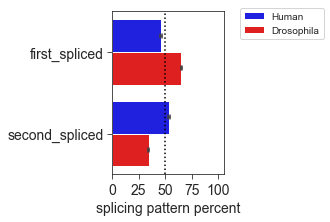

In [26]:
# Plot for Figure 3B

# get splicing order dataframe for K562 cells
K562_1_splicing_order_df = get_both_splicing_order_df(K562_1_intron_pairs_df)
K562_2_splicing_order_df = get_both_splicing_order_df(K562_2_intron_pairs_df)
K562_3_splicing_order_df = get_both_splicing_order_df(K562_3_intron_pairs_df)
K562_4_splicing_order_df = get_both_splicing_order_df(K562_4_intron_pairs_df)
K562_5_splicing_order_df = get_both_splicing_order_df(K562_5_intron_pairs_df)

# get splicing order dataframe for S2 cells
S2_1_splicing_order_df = get_both_splicing_order_df(S2_1_intron_pairs_df)
S2_2_splicing_order_df = get_both_splicing_order_df(S2_2_intron_pairs_df)
S2_3_splicing_order_df = get_both_splicing_order_df(S2_3_intron_pairs_df)

K562_splicing_order_df = pd.concat([K562_1_splicing_order_df,K562_2_splicing_order_df,K562_3_splicing_order_df,K562_4_splicing_order_df,K562_5_splicing_order_df]).reset_index(drop=True)
K562_splicing_order_df['name'] = 'Human'

S2_splicing_order_df = pd.concat([S2_1_splicing_order_df,S2_2_splicing_order_df,S2_3_splicing_order_df])
S2_splicing_order_df['name'] = 'Drosophila'

all_splicing_order_df = pd.concat([K562_splicing_order_df,S2_splicing_order_df])
                                   
fig, ax = plt.subplots(figsize=(2,3))

sns.barplot(x="splicing_status", y="order", hue="name", data=all_splicing_order_df, palette=['blue','red'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlabel("splicing pattern percent", fontsize=14)
plt.ylabel("", fontsize=14)

plt.xticks([0,25,50,75,100], fontsize=12)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,105)
plt.axvline(x=50, color='black', linestyle=":")

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.savefig('/path/to/Figure_4B_K562_S2_order_of_splicing_horizontal_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()




In [27]:
print("K562 first spliced counts: "+str(np.sum(K562_splicing_order_counts['yes_no'])))
print("K562 second spliced counts: "+str(np.sum(K562_splicing_order_counts['no_yes'])))
      
p = stats.binom_test([np.sum(K562_splicing_order_counts['yes_no']),np.sum(K562_splicing_order_counts['no_yes'])], n=None, p=0.5)
print("K562 p-value: "+str(p))


K562 first spliced counts: 2845
K562 second spliced counts: 3179
K562 p-value: 1.7749136051513946e-05


In [28]:
print("S2 first spliced counts: "+str(np.sum(S2_splicing_order_counts['yes_no'])))
print("S2 second spliced counts: "+str(np.sum(S2_splicing_order_counts['no_yes'])))

p = stats.binom_test([np.sum(S2_splicing_order_counts['yes_no']),np.sum(S2_splicing_order_counts['no_yes'])], n=None, p=0.5)
print("S2 p-value: "+str(p))


S2 first spliced counts: 3446
S2 second spliced counts: 1820
S2 p-value: 7.335510781829919e-113


In [45]:
# FIGURE 4C-D - splicing order frequencies across intron pairs

# get the frequency of splicing order across reads that cover the same introns
def get_pair_splcing_frequencies(intron_pairs_df):

    pair_dict = {}

    for i in range(0,len(intron_pairs_df)):

        read = intron_pairs_df.iloc[i]['read']
        chrom = intron_pairs_df.iloc[i]['chrom']
        int1_start = intron_pairs_df.iloc[i]['int1_start']
        int1_end = intron_pairs_df.iloc[i]['int1_end']
        int2_start = intron_pairs_df.iloc[i]['int2_start']
        int2_end = intron_pairs_df.iloc[i]['int2_end']
        strand = intron_pairs_df.iloc[i]['strand']
        int1_splice = intron_pairs_df.iloc[i]['int1_splice']
        int2_splice = intron_pairs_df.iloc[i]['int2_splice']
        transcript = intron_pairs_df.iloc[i]['transcript']

        pair_coord = str(chrom)+"_"+str(int1_start)+"_"+str(int1_end)+"_"+str(int2_start)+"_"+str(int2_end)+"_"+str(strand)+"_"+str(transcript)

        if (strand == "-"):
            x = int1_splice
            int1_splice = int2_splice
            int2_splice = x

        if pair_coord not in pair_dict.keys():

            if (int1_splice=="YES") & (int2_splice=="YES"):
                pair_dict[pair_coord] = [1,0,0,0]

            if (int1_splice=="YES") & (int2_splice=="NO"):
                pair_dict[pair_coord] = [0,1,0,0]

            if (int1_splice=="NO") & (int2_splice=="YES"):
                pair_dict[pair_coord] = [0,0,1,0]

            if (int1_splice=="NO") & (int2_splice=="NO"):
                pair_dict[pair_coord] = [0,0,0,1]

        elif pair_coord in pair_dict.keys():
            if (int1_splice=="YES") & (int2_splice=="YES"):
                pair_dict[pair_coord][0] += 1

            if (int1_splice=="YES") & (int2_splice=="NO"):
                pair_dict[pair_coord][1] += 1

            if (int1_splice=="NO") & (int2_splice=="YES"):
                pair_dict[pair_coord][2] += 1

            if (int1_splice=="NO") & (int2_splice=="NO"):
                pair_dict[pair_coord][3] += 1

    pair_df = pd.DataFrame.from_dict(pair_dict, orient='index')
    pair_df.columns = ['YES_YES','YES_NO','NO_YES','NO_NO']   

    return pair_df
    

In [46]:
# load intron files
hg38_introns = pd.read_csv('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed',sep='\t',header=None,low_memory=False)
hg38_introns.columns = ['chrom','start','end','name','score','strand']
hg38_introns['transcript'] = hg38_introns.apply(lambda row: row['name'].split('_intron')[0].split('.')[0], axis=1)
hg38_introns = hg38_introns.drop_duplicates(['chrom','start','end','strand']).reset_index(drop=True)

dm6_introns = pd.read_csv('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed',sep='\t',header=None,low_memory=False)
dm6_introns.columns = ['chrom','start','end','name','score','strand']
dm6_introns['chrom'] = 'chr'+dm6_introns['chrom']
dm6_introns['transcript'] = dm6_introns.apply(lambda row: row['name'].split('_intron')[0].split('.')[0], axis=1)
dm6_introns = dm6_introns.drop_duplicates(['chrom','start','end','strand']).reset_index(drop=True)

# concat intron pair datasets into each species
K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df,K562_2_intron_pairs_df,K562_3_intron_pairs_df,K562_4_intron_pairs_df,K562_5_intron_pairs_df], axis=0)
S2_intron_pairs_df = pd.concat([S2_1_intron_pairs_df,S2_2_intron_pairs_df,S2_3_intron_pairs_df], axis=0)

# merge intron pairs with transcript name file
K562_intron_pairs_df = pd.merge(K562_intron_pairs_df,hg38_introns,left_on=['chrom','int1_start','int1_end','strand'],right_on=['chrom','start','end','strand'],how='left')
K562_intron_pairs_df = K562_intron_pairs_df.drop(['start','end','name','score'], axis=1)

S2_intron_pairs_df = pd.merge(S2_intron_pairs_df,dm6_introns,left_on=['chrom','int1_start','int1_end','strand'],right_on=['chrom','start','end','strand'],how='left')
S2_intron_pairs_df = S2_intron_pairs_df.drop(['start','end','name','score'], axis=1)


In [47]:
# get intron pair splicing order frequencies
K562_pair_spicing_freq = get_pair_splcing_frequencies(K562_intron_pairs_df)
S2_pair_spicing_freq = get_pair_splcing_frequencies(S2_intron_pairs_df)


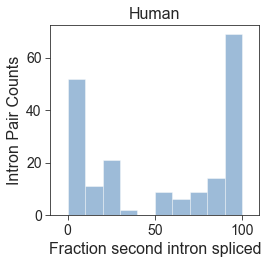

In [54]:
top_K562_pair_spicing_freq = K562_pair_spicing_freq[K562_pair_spicing_freq['YES_NO']+K562_pair_spicing_freq['NO_YES'] >= 4]
K562_percent_first_spliced = (top_K562_pair_spicing_freq['NO_YES']/(top_K562_pair_spicing_freq['NO_YES']+top_K562_pair_spicing_freq['YES_NO']))*100

fig, ax = plt.subplots(figsize=(3.75,3.5))

sns.distplot(K562_percent_first_spliced, bins=10, kde=False, color=sns.color_palette("Blues")[5])

plt.xlim(-10,110)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlabel("Fraction second intron spliced", fontsize=16)
plt.ylabel("Intron Pair Counts", fontsize=16)

plt.title('Human', fontsize=16)

plt.savefig('/path/to/Figure_4C_K562_splicing_order_within_pairs_barchart.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()



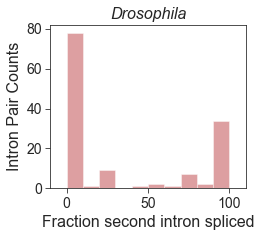

In [143]:
top_S2_pair_spicing_freq = S2_pair_spicing_freq[S2_pair_spicing_freq['YES_NO']+S2_pair_spicing_freq['NO_YES'] >= 4]
S2_percent_first_spliced = (top_S2_pair_spicing_freq['NO_YES']/(top_S2_pair_spicing_freq['NO_YES']+top_S2_pair_spicing_freq['YES_NO']))*100

fig, ax = plt.subplots(figsize=(3.5,3))

sns.distplot(S2_percent_first_spliced, bins=10, kde=False, color=sns.color_palette("Reds")[5])

plt.xlim(-10,110)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlabel("Fraction second intron spliced", fontsize=16)
plt.ylabel("Intron Pair Counts", fontsize=16)

plt.title('Drosophila',fontstyle='oblique', fontsize=16)

plt.savefig('/path/to/Figure_4D_S2_splicing_order_within_pairs_barchart.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [49]:
len(top_K562_pair_spicing_freq)

193

In [145]:
len(top_S2_pair_spicing_freq)

135

In [146]:
biased = len(S2_percent_first_spliced[(S2_percent_first_spliced==0.0) | (S2_percent_first_spliced==100.0)]) 
total = len(S2_percent_first_spliced)
S2_percent = biased/total*100
S2_genes = set(pd.DataFrame(top_S2_pair_spicing_freq.index).apply(lambda row: 'NM_'+str(row[0].split('NM_')[1]), axis=1))

print('S2 total: '+str(total))
print('S2 unique genes: '+str(len(S2_genes)))
print('S2 all spliced or not spliced: '+str(round(S2_percent,2)))


S2 total: 135
S2 unique genes: 115
S2 all spliced or not spliced: 82.22


In [50]:
biased = len(K562_percent_first_spliced[(K562_percent_first_spliced==0.0) | (K562_percent_first_spliced==100.0)]) 
total = len(K562_percent_first_spliced)
K562_percent = biased/total*100
K562_genes = set(pd.DataFrame(top_K562_pair_spicing_freq.index).apply(lambda row: 'NM_'+str(row[0].split('NM_')[1]), axis=1))

print('K562 total: '+str(total))
print('K562 unique genes: '+str(len(K562_genes)))
print('K562 all spliced or not spliced: '+str(round(K562_percent,2)))



K562 total: 193
K562 unique genes: 127
K562 all spliced or not spliced: 61.14
